In [1]:
from functools import partial
from jax import random, jit
import jax.numpy as jnp
import utils
import interp
import randgen

from io_tools import Map, MapRegBin
import interp

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".30"

In [3]:
par_dict = {
    "fano": 0.059,
    "W": 0.013509665661431896, 
    "Nex/Ni": 0.08237994367314523, 
    "g1": 0.15008491987690997, 
    "g2": 16.52840260432468, 
    "p_dpe": 0.2873015066181266, 
    "py0": 0.12644250072199228, 
    "py1": 43.12392476032283, 
    "py2": -0.30564651066249543, 
    "py3": 0.937555814189728, 
    "py4": 0.5864910020458629, 
    "rf0": 0.029414125811261564, 
    "rf1": 0.2571929264699089,
    "field": 23.,
    "drift_velocity": 0.0677,
    "gas_gain": 31.3,
    "s2_threshold": 500,
}

In [4]:
def get_energy(key, num_sim):
    key, energy = randgen.uniform(key, 0.01, 30., shape=(num_sim, ))
    return key, energy

def get_num_quanta(key, energy):
    num_quanta_mean = energy / par_dict['W']
    num_quanta_std = jnp.sqrt(num_quanta_mean * par_dict['fano'])
    key, num_quanta = randgen.truncate_normal(key, num_quanta_mean, num_quanta_std, vmin=0)
    return key, num_quanta.round().astype(int)

def get_num_ion(key, num_quanta):
    p_ion = 1. / (1. + par_dict['Nex/Ni'])
    key, num_ion = randgen.binomial(key, p_ion, num_quanta)
    return key, num_ion

def get_mean_mTI_recomb(energy):
    ni = energy / par_dict['W'] / (1. + par_dict['Nex/Ni'])
    ti = ni * par_dict['py0'] * jnp.exp(- energy / par_dict['py1']) * par_dict['field']**par_dict['py2'] / 4.
    fd = 1. / (1. + jnp.exp(- (energy - par_dict['py3']) / par_dict['py4']))
    r = jnp.where(
        ti < 1e-2, 
        ti / 2. - ti * ti / 3., 
        1. - jnp.log(1. + ti) / ti
    )
    return r * fd

def get_std_recomb(energy):
    return jnp.clip(par_dict['rf0'] * (1. - jnp.exp(- energy / par_dict['rf1'])), 0, 1.)

def get_true_recomb(key, r_mean, r_std):
    return randgen.truncate_normal(key, r_mean, r_std, vmin=0., vmax=1.)

def get_num_electron(key, num_ion, r_true):
    p_not_recomb = 1. - r_true
    return randgen.binomial(key, p_not_recomb, num_ion)

In [5]:
z_sim_range = (-133.97, -13.35)
r_sim_max = 60.

elife_map = Map('./data/elife.json')
s1_correction_map = MapRegBin('./data/s1_correction_map_regbin.json')
s2_correction_map = MapRegBin('./data/s2_correction_map_regbin.json')

def get_position(key, num_sim):
    key, z = randgen.uniform(key, z_sim_range[0], z_sim_range[1], shape=(num_sim, ))
    key, r2 = randgen.uniform(key, 0, r_sim_max**2, shape=(num_sim, ))
    r = jnp.sqrt(r2)
    key, theta = randgen.uniform(key, 0, 2*jnp.pi, shape=(num_sim, ))
    
    x = r * jnp.cos(theta)
    y = r * jnp.sin(theta)
    return key, x, y, z

def get_s1_correction(x, y, z):
    pos = jnp.stack([x, y, z]).T
    s1_correction = interp.map_interpolator_regular_binning_3d(
        pos,
        s1_correction_map.coordinate_lowers,
        s1_correction_map.coordinate_uppers,
        s1_correction_map.map
    )
    return s1_correction

def get_s2_correction(x, y):
    pos = jnp.stack([x, y]).T
    s2_correction = interp.map_interpolator_regular_binning_2d(
        pos,
        s2_correction_map.coordinate_lowers,
        s2_correction_map.coordinate_uppers,
        s2_correction_map.map
    )
    return s2_correction

def get_s1_num_phd(key, num_photon, s1_correction):
    g1_true_no_dpe = jnp.clip(par_dict['g1'] * s1_correction / (1. + par_dict['p_dpe']), 0, 1.)
    key, num_s1_phd = randgen.binomial(key, g1_true_no_dpe, num_photon)
    return key, num_s1_phd

def get_s1_num_pe(key, num_s1_phd):
    key, num_s1_dpe = randgen.binomial(key, par_dict['g1'], num_s1_phd)
    return key, num_s1_dpe + num_s1_phd

def get_drift_survive_prob(key, z):
    key, p = randgen.uniform(key, 0, 1., shape=jnp.shape(z))
    lifetime = interp.curve_interpolator(p, elife_map.coordinate_system, elife_map.map)
    drift_survive_prob = jnp.exp(- jnp.abs(z) / par_dict['drift_velocity'] / lifetime)
    
    return key, drift_survive_prob

def get_num_electron_drifted(key, num_electron, drift_survive_prob):
    key, num_electron_drifted = randgen.binomial(key, drift_survive_prob, num_electron)
    
    return key, num_electron_drifted

def get_s2_num_pe(key, num_electron_drifted, s2_correction):
    extraction_eff = par_dict['g2'] / par_dict['gas_gain']
    g2_true = par_dict['g2'] * s2_correction
    gas_gain_true = g2_true / extraction_eff
    
    key, num_electron_extracted = randgen.binomial(key, extraction_eff, num_electron_drifted)
    
    mean_s2_pe = num_electron_extracted * gas_gain_true
    key, num_s2_pe = randgen.truncate_normal(
        key,
        mean_s2_pe,
        jnp.sqrt(mean_s2_pe),
        vmin=0
    )
    
    return key, num_s2_pe

In [6]:
s1_bias = Map('./data/s1_bias.json')
s1_smear = Map('./data/s1_smearing.json')
s2_bias = Map('./data/s2_bias.json')
s2_smear = Map('./data/s2_smearing.json')

def get_s1(key, num_s1_phd, num_s1_pe):
    mean = interp.curve_interpolator(num_s1_phd, s1_bias.coordinate_system, s1_bias.map)
    std = interp.curve_interpolator(num_s1_phd, s1_smear.coordinate_system, s1_smear.map)
    
    key, bias = randgen.normal(key, mean, std)
    return key, num_s1_pe * (1. + bias)

def get_s2(key, num_s2_pe):
    mean = interp.curve_interpolator(num_s2_pe, s2_bias.coordinate_system, s2_bias.map)
    std = interp.curve_interpolator(num_s2_pe, s2_smear.coordinate_system, s2_smear.map)
    
    key, bias = randgen.normal(key, mean, std)
    return key, num_s2_pe * (1. + bias)

In [7]:
s1_eff = Map('./data/3fold_recon_eff.json')

def get_s1_eff(num_s1_phd):
    return interp.curve_interpolator(num_s1_phd, s1_eff.coordinate_system, s1_eff.map)

In [10]:
@utils.timeit
@partial(jit, static_argnums=(1, ))
def sim(key, num_sim):
    key, energy = get_energy(key, num_sim)
    key, x, y, z = get_position(key, num_sim)
    
    # sim quanta
    key, num_quanta = get_num_quanta(key, energy)
    key, num_ion = get_num_ion(key, num_quanta)
    
    r_mean = get_mean_mTI_recomb(energy)
    r_std = get_std_recomb(energy)
    key, r_true = get_true_recomb(key, r_mean, r_std)
    
    key, num_electron = get_num_electron(key, num_ion, r_true)
    num_photon = num_quanta - num_electron
    
    # detector response
    s1_correction = get_s1_correction(x, y, z)
    s2_correction = get_s2_correction(x, y)
    
    key, num_s1_phd = get_s1_num_phd(key, num_photon, s1_correction)
    key, num_s1_pe = get_s1_num_pe(key, num_s1_phd)
    
    key, drift_survive_prob = get_drift_survive_prob(key, z)
    key, num_electron_drifted = get_num_electron_drifted(key, num_electron, drift_survive_prob)
    key, num_s2_pe = get_s2_num_pe(key, num_electron_drifted, s2_correction)
    
    # reconstruction
    key, s1 = get_s1(key, num_s1_phd, num_s1_pe)
    key, s2 = get_s2(key, num_s2_pe)
    
    cs1 = s1 / s1_correction
    cs2 = s2 / s2_correction / drift_survive_prob
    
    # efficiency
    eff = get_s1_eff(num_s1_phd)
    eff = eff * jnp.where(s2 > par_dict['s2_threshold'], 1., 0)
    
    return key, cs1, num_s2_pe/drift_survive_prob, eff

In [11]:
seed = 980906
batch_size = int(1e6)
key = random.PRNGKey(seed)

sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 6481.884718 msec. 


(DeviceArray([ 543426856, 3444466698], dtype=uint32),
 DeviceArray([273.91217 ,   6.398053, 217.08995 , ..., 126.39105 ,
               65.5165  ,   6.597642], dtype=float32),
 DeviceArray([6503.3003, 1794.0521, 5776.393 , ..., 5333.694 , 5415.7764,
              1207.8301], dtype=float32),
 DeviceArray([1.        , 0.67083734, 1.        , ..., 1.        ,
              0.9986111 , 0.9016649 ], dtype=float32))

In [18]:
for _ in range(100):
    key, cs1, cs2, eff = sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 3.066540 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 2.685547 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 4.695177 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 14.054060 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 12.396812 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 10.029078 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 11.899948 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 14.503717 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.969421 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 9.734869 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 14.508486 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 8.248568 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 9.769678 msec. 
 Function <sim> st

In [16]:
ces = 0.0137*(cs1/0.15+cs2/16.)

In [24]:
hist1, _ = jnp.histogram(ces, bins=jnp.linspace(0, 10, 100), weights=eff)
hist0, _ = jnp.histogram(ces, bins=jnp.linspace(0, 10, 100))

In [29]:
hist1, _ = np.histogram(np.array(ces), bins=np.linspace(0, 10, 100), weights=np.array(eff))

In [35]:
jnp.any(ces == np.nan)

DeviceArray(False, dtype=bool)

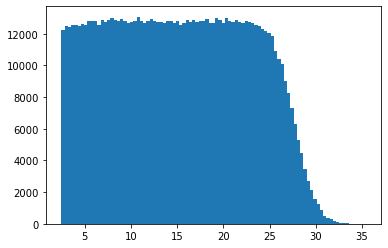

In [19]:
plt.hist(np.array(ces), bins=100, weights=np.array(eff))
plt.show()

In [11]:
h, bin_egdes = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T,
    bins=(jnp.linspace(0,100,101), jnp.logspace(2.5,4.1,81)),
    weights=eff
)

In [12]:
import numpy as np
import multihist as mh
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

h = np.array(h)
hist = mh.Histdd.from_histogram(h, bin_egdes, axis_names=['cs1', 'cs2'])

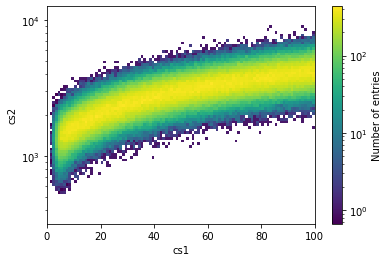

In [13]:
hist.plot(norm=LogNorm())
plt.yscale('log')
plt.show()